In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , distinct,desc

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [27]:
# View all of the classes that automap found
for cls in Base.classes:
    print(cls.__name__)

measurement
station


In [28]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

# Print the most recent date
print("The most recent date in the data set is:", most_recent_date[0])

The most recent date in the data set is: 2017-08-23


            prcp
Date            
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00


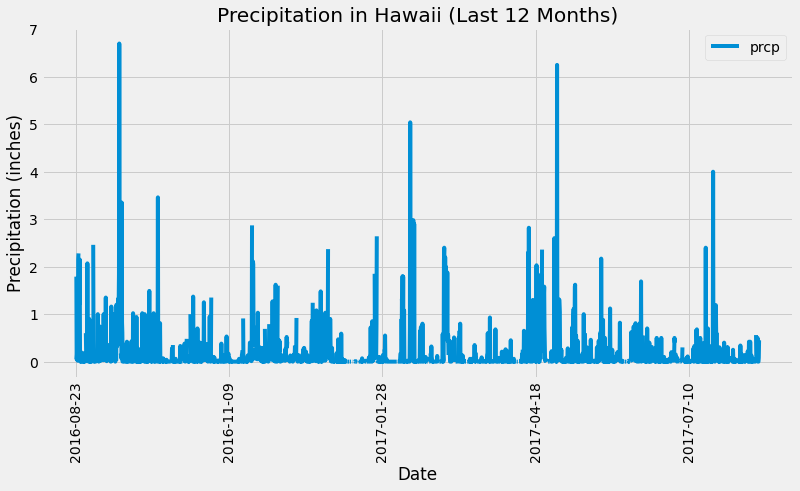

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_s = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
most_recent_date = pd.to_datetime(most_recent_date_s)

# Calculate the date one year from the last date in data set.
one_year_ago_date = most_recent_date - pd.DateOffset(years=1)
one_year_ago_date_str = one_year_ago_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'prcp'])
df.set_index('Date', inplace=True)
print(df.head())

# Sort the dataframe by date

df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data


df.plot(figsize=(12,6))
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=90)
plt.show()

In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(df['prcp'].describe())

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(func.count(distinct(Station.station))).scalar()
print(f'Total number of stations: {num_stations}')

Total number of stations: 9


In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc())\
                         .all()

for station, count in active_stations:
    print(f'{station}: {count}')

USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temp_stats = session.query(func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs))\
                    .filter(Measurement.station == most_active_station)\
                    .all()

print(f"Lowest temperature recorded at {most_active_station}: {temp_stats[0][0]} F")
print(f"Highest temperature recorded at {most_active_station}: {temp_stats[0][1]} F")
print(f"Average temperature recorded at {most_active_station}: {temp_stats[0][2]} F")

Lowest temperature recorded at USC00519281: 54.0 F
Highest temperature recorded at USC00519281: 85.0 F
Average temperature recorded at USC00519281: 71.66378066378067 F


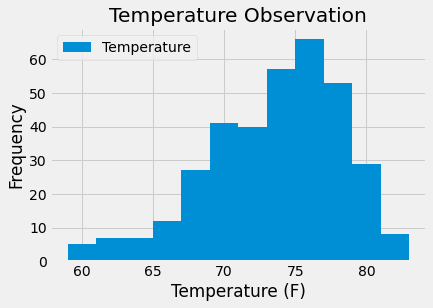

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs)\
            .filter(Measurement.station == most_active_station)\
            .filter(Measurement.date >= one_year_ago_date.strftime('%Y-%m-%d'))\
            .all()

# Convert the query results to a DataFrame
temp_df = pd.DataFrame(temp_data, columns=['Temperature (F)'])

# Plot a histogram of the temperature data with 12 bins
plt.hist(temp_df['Temperature (F)'], bins=12, label='Temperature')

# Set chart labels
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation')
# Show the chart legend
plt.legend()

# Display the chart
plt.show()

# Close session

In [37]:
# Close Session
session.close()